# Fractal Aggregate Aerosols in a Hot Jupiter atmosphere

In this tutorial, we will learn:

1. How to run virga for non-spherical cloud particles. 
2. How to compare the particle sizes and optical properties for aggregates vs. spheres

Aerosols can come in a variety of shapes and sizes, which we typically characterise by their fractal dimension (Df). Under this framework, aerosols are made of collections of small spheres called monomers, and Df=3 would represent the most compact possible arrangement, whereas Df=1 would be something perfectly linear. Real aerosols are usually somewhere in-between 1 and 3, and the ultimate shape of an aerosol is usually a result of their formation conditions. VIRGA v2.0 allows us to silmultaneously model the effects of a range of different particle shapes on spectra so we can find the best fit to observational data. For further details and example of typical shapes, see Lodge & Moran et al. (2025).

Striving to maintain the simplicity and ethod of virga, aerosols can be added by providing two simple parameters:

    a) The fractal dimension (general shape) of the aerosols (which can be an array).
    b) EITHER the number of monomers (N_mon) OR the radius of the monomer (r_mon).

Figure 2 of Moran & Lodge et al. (2025) demonstrates both of the choices for (b) and explains them in detail -- see this for more guidance. in this tutorial we will choose an array of fractal dimensions, and we choose to fix the number of monomers ($N_{mon}$=1000).

Before beginning, make sure you have downloaded the new optical database for aggregates from here: https://zenodo.org/records/16581692 (which are all calculated with the assumption that $N_{mon}$=1000) and update the filepaths to the VIRGA reference data in the first cell:

In [1]:
# --------------------------------------------- UPDATE THESE FILEPATHS FOR YOUR OWN SETUP ------------------------------------------------------------------

# first, set the locations of databases needed for virga
mieff_dir = '/Users/nbatalh1/Documents/data/VIRGA_2_mieff_files' # set file paths for VIRGA v2 optical database (.mieff files) -- make sure you have downloaded the new database that includes aggregates (v2!)

# --------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
#standard import statements
import numpy as np
import pandas as pd
import astropy.units as u
from virga import justdoit as vdi

#plotting tools
from virga import justplotit as vpi
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
output_notebook()
import matplotlib.pyplot as plt 

Loading BokehJS ...

## Set planet parameters

To start with, let's create choose a standard hot Jupiter profile and a condensible species for the clouds. Here we choose Mg<sub>2</sub>SiO<sub>4</sub>, a common species for these environments.

In [3]:
# set planet parameters: 

planet_mass = 1 # M_Jup
planet_radius = 1 # R_Jup

# choose condensible species
aggregate_species = ['Mg2SiO4'] # Aggregate species

# set Kzz, metallicity and mean molecular weight 
metallicity = 1 #atmospheric metallicity relative to Solar
mean_molecular_weight = 2.3 # atmospheric mean molecular weight
constant_kzz = 10**10 # constant Kzz
f_sed = 0.5 # sedimentation efficiency
sigma_width = 2 # width of lognormal distribution

# create hot Jupiter atmosphere
jupiter = vdi.Atmosphere(aggregate_species, 
                         fsed=f_sed,
                         mh=metallicity,
                         mmw = mean_molecular_weight, 
                         sig = sigma_width,
                         aggregates=False)

# set gravity
jupiter.gravity(mass=planet_mass, mass_unit=vdi.u.Unit('M_jup'), radius=planet_radius, radius_unit=vdi.u.Unit('R_jup')) # order: planet mass, unit, planet radius, unit

# load preset hot jupiter p-T profile
jupiter.ptk(df = vdi.hot_jupiter())

# add constant Kzz (value set by user at top of this cell) to atmosphere profile
jupiter.kz = np.zeros(len(jupiter.kz))+ constant_kzz # make a constant Kzz profile as an array

## Adding Mg<sub>2</sub>SiO<sub>4</sub> Clouds (Spherical Particles)

In [4]:
# run virga: this will determine where the clouds are, what particles sizes they are made from, and how opaque they are at each pressure level
clouds_from_virga_spheres = vdi.compute(jupiter, directory=mieff_dir) # Add the Mg2SiO4 clouds!

## p-T profile

To view the p-T profile and get an idea of where in the atmosphere our Mg<sub>2</sub>SiO<sub>4</sub> condensates are forming into clouds, we can use virga's usual pt() function.

In [5]:
# Plot pressure-Temperature profile
show(vpi.pt(clouds_from_virga_spheres,plot_height=450))

## Adding Fractal Aggregate (Mg<sub>2</sub>SiO<sub>4</sub>) Clouds.

Everything up to this point has been the same method as for Virga v1.0. Now let's add fractal aggregate clouds to our clear model instead of spheres. The function is very similar, but we just provide two extra bits of information (fractal dimension and number of monomers). We have added a loop below to make clouds for five different fractal dimensions and save the output to a list.

In [6]:
# Set a range of fractal dimensions to explore (a different model will be run each time). This can be a single value or an array. 
# In this example, we will choose the values [1.2, 1.6, 2.0, 2.4, 2.8]:
d_f_values = np.linspace(1.2,2.8,5)

# create a list to store all of the different cloud models for each fractal dimension
clouds_from_virga_fractals=[]

# loop over all particle shapes
for i in range(len(d_f_values)):


    d_f = d_f_values[i]
    N_monomers = 1000 # Here we provide the number of monomers. If you prefer to provide r_mon instead, set it here (but note that it needs to be in cm, not um), and submit r_mon instead of N_mon in the .virga() function below
    
    jupiter.aggregates=True
    jupiter.Df= d_f
    jupiter.N_mon = N_monomers
    # That's it -- Df and N_mon are all you need to prescribe for aggregates! More details on other typical aggregate parameters below for experts:
    # k0 will usually be calculated using Eq. 14+15 of Moran & Lodge et al. (2025), but this can be prescribed here if you wish to use a fixed value.
    # Radius of gyration will be calculated within the code: virga can calculate the mass of the each aggregate, meaning that r_mon can be calculated
    # from N_mon (or vice versa). k0 is calculated as stated above, so including Df we have everything we need to find R_gyr using Eq. 2 of Moran & Lodge 
    # et al. (2025)

    # take the clear atmosphere (cloudy_jupiter_list[i]) and run virga to find the clouds for each fractal dimension (using aggregates=True and our aggregate parameters). 
    # this method saves each cloud model as a new model in a list (clouds_from_virga_fractals).
    clouds_from_virga_fractals.append(vdi.compute(jupiter, directory=mieff_dir)) # Add the Mg2SiO4 clouds!

Optics file found. Reading data from: /Users/nbatalh1/Documents/data/VIRGA_2_mieff_files/Mg2SiO4_aggregates_Df_1.200000.mieff.


Optics file found. Reading data from: /Users/nbatalh1/Documents/data/VIRGA_2_mieff_files/Mg2SiO4_aggregates_Df_1.600000.mieff.


Optics file found. Reading data from: /Users/nbatalh1/Documents/data/VIRGA_2_mieff_files/Mg2SiO4_aggregates_Df_2.000000.mieff.


Optics file found. Reading data from: /Users/nbatalh1/Documents/data/VIRGA_2_mieff_files/Mg2SiO4_aggregates_Df_2.400000.mieff.


Optics file found. Reading data from: /Users/nbatalh1/Documents/data/VIRGA_2_mieff_files/Mg2SiO4_aggregates_Df_2.800000.mieff.


## Aggregate Analysis Tools

We've made our clouds! Now let's see how the aggregates compared to spheres. There are a number of tools that have been added to compare between the different models, and each one can give you interesting diagnostic information. Let's explore them one-by-one. First, set-up the figure size and the min/max wavelength to plot.

In [7]:
# set figure size in notebook
plt.rcParams['figure.figsize'] = [15, 10]

# set min and max wavelength to show on plots
min_wavelength = 0.3 # in um
max_wavelength = 15 # in um

# set custom colors for plots
cloud_colors = ['#ce3fce', '#7cf2fb', '#33b9cc', '#1c7bb8', '#295091', '#212255'] # order: spheres, 1.2, 1.6, 2.0, 2.4, 2.8

## Visualising Particle Sizes in each Pressure Layer

Virga will typically find different particle sizes for different aggregate shapes because of how they behave dynamically (see Moran & Lodge et al. 2025). Lower fractal dimensions tend to form into larger particles (because they have slower fall speed vs compact spheres. However, the upwards forces are the same in both versions of the model. Therefore, the aggregates need to form into more massive particles to stay stable against the same upwards velocity from Kzz/convection). The mean particle sizes that virga found for each shape can be seen and compared using the tool below. 

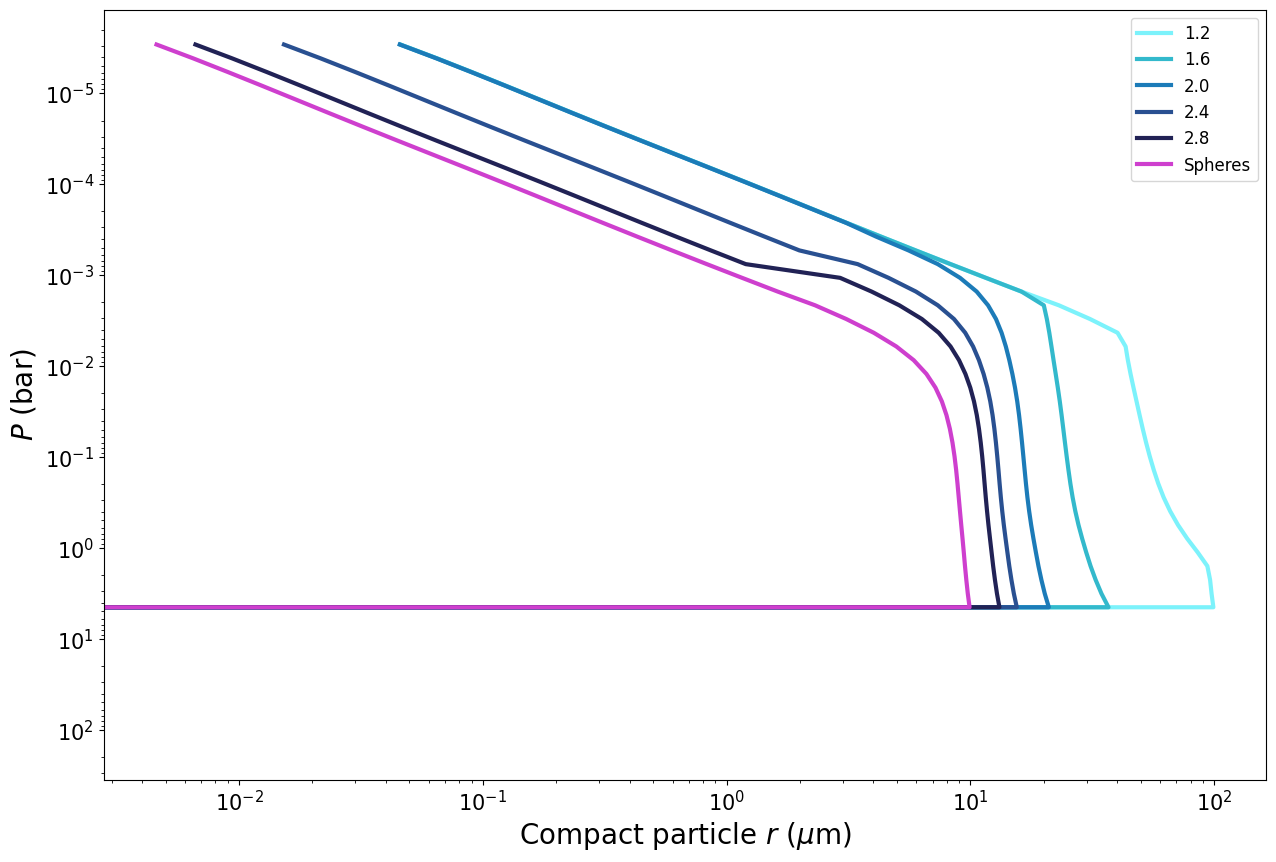

In [8]:
vpi.aggregates_pressure_vs_radius(clouds_from_virga_spheres, clouds_from_virga_fractals, d_f_list=d_f_values, colors=cloud_colors)


<b>Interpretation:</b> The Df=1.2 model has the largest particles, which are at the bottom of the cloud-deck. In all models, cloud particles get smaller as altitude increases.

## Probing the relationship between Pressure, Radius and Number Density

Because the same amount of condensate is condensing out in each model in virga (regardless of particle shape), if the low fractal dimensions form into larger particles, there must be fewer of them. Plotting the number density at each pressure layer shows demonstrates this balance between particle size and number density visually with altitude. The marker size indicates particle size. 

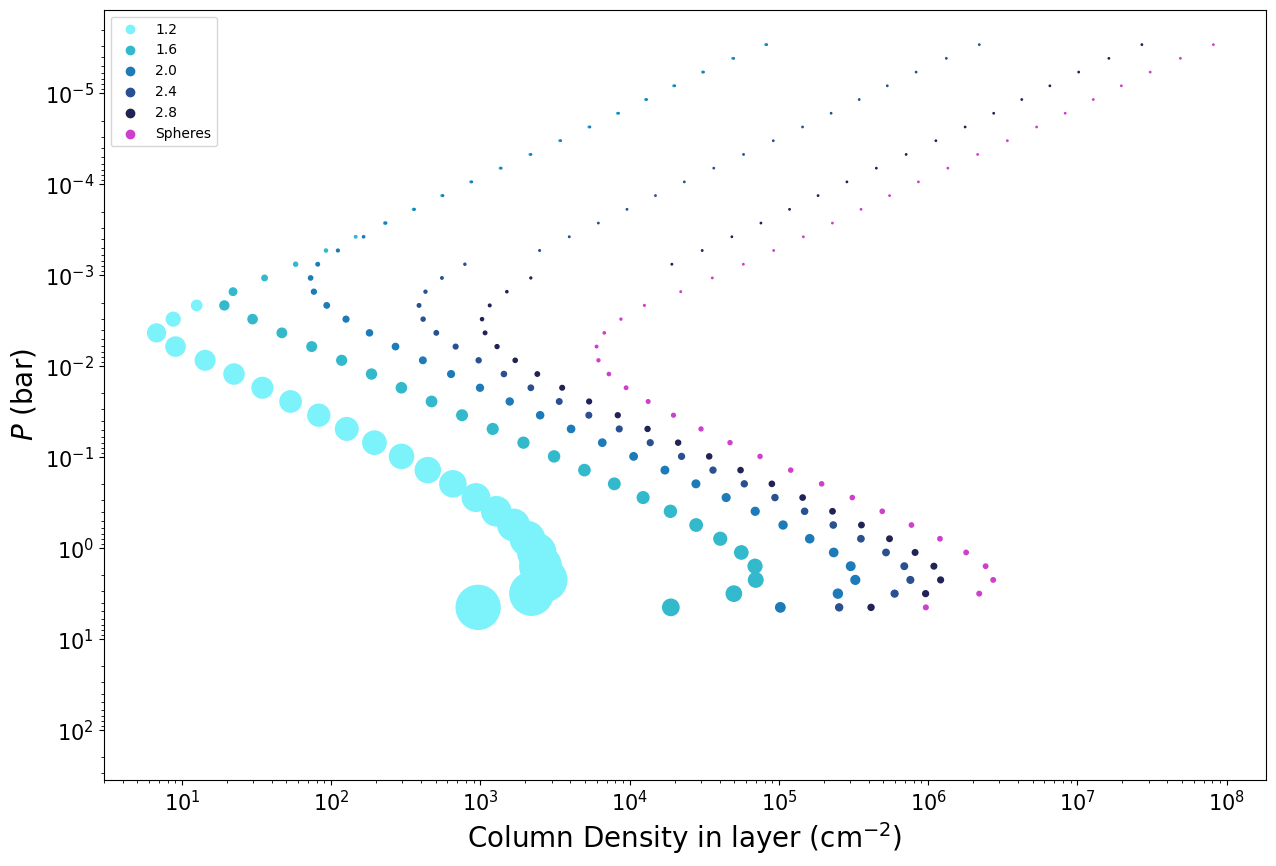

In [9]:
vpi.aggregates_pressure_vs_number_density(clouds_from_virga_spheres, clouds_from_virga_fractals, d_f_list=d_f_values, colors=cloud_colors)

<b>Interpretation:</b> The Df=1.2 clouds are shown to be made of fewer (but larger) particles than in the other models, just like in Figure 4 of Lodge & Moran et al. (2025).

## Visualising .mieff files and Optical Properties

This tool allows you to see how the optical properties of the cloud particles vary with shape. $Q_{ext}$ represents how efficiently they will absorb and scatter radiation, and it is a function of particle size, wavelength and shape. This reads all of the data from the .mieff database and plots $Q_{ext}$ for all particle sizes (blue = smallest particles in the grid, green = largest particles in the grid).


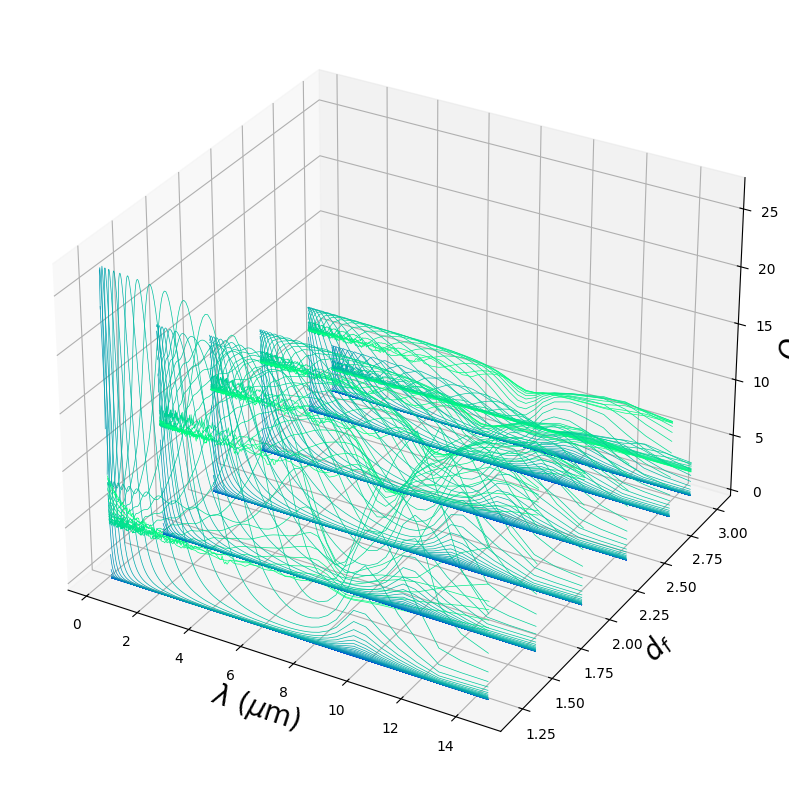

In [10]:
# plot Q_ext as a function of wavelength for each fractal dimension
vpi.aggregates_optical_properties(aggregate=aggregate_species[0], mieff_dir=mieff_dir, d_f_list=d_f_values, min_wavelength=min_wavelength, max_wavelength=max_wavelength)

<b>Interpretation:</b> This is usually a busy plot, but it is useful because it can provide intuition into how linear and compact aggregates compare to their spherical counterparts. Here the linear fractals with Df = 1.2 are the most opaque at short wavelengths. We saw that these particles are the least opaque in the transmission spectrum, which is because their number density is so much lower as shown in the previous figure.

These plots can highlight resonance features and aid in checking that your optics are behaving as expected for a particular chemical species.

## Checking that Particle Radii are within the .mieff Grid

It's important that virga finds particles that are within the range of optical properties in the .mieff grid, otherwise virga may underpredict or overpredict the opacity of the particles. Virga will give warnings if it finds particles off-grid, but this plot is a quick visual check to see if and where that happens:

For the Mg2SiO4.mieff file (spheres):

	 Wavelengths are between 0.268 --> 29.700 um in 189 intervals.
	 Radii are between 0.0001 --> 100.0 um in 60 intervals.

Good news - all aggregates are within the grid!


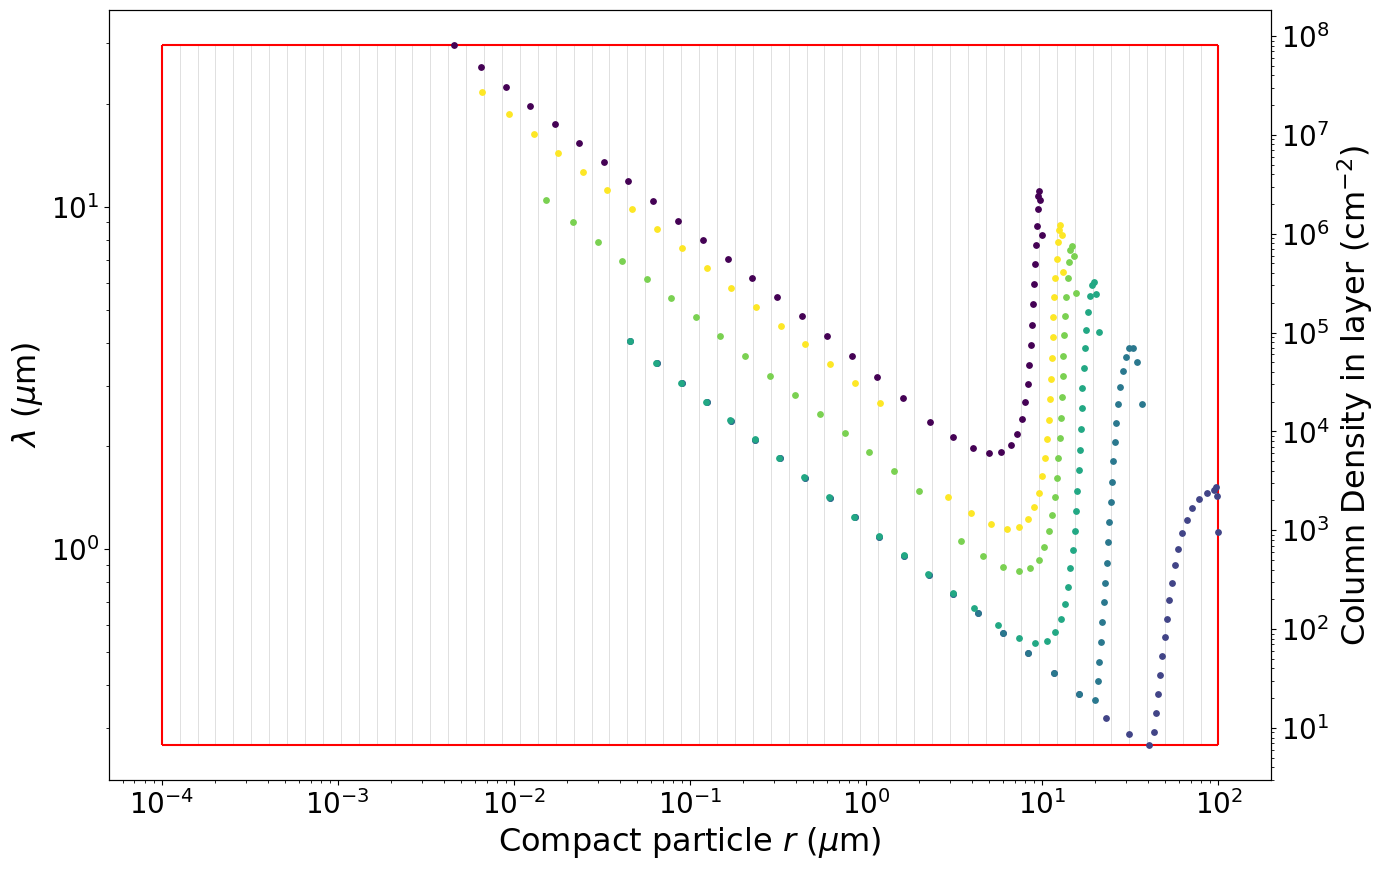

In [11]:
vpi.aggregates_wavelength_radius_grid(clouds_from_virga_spheres, clouds_from_virga_fractals, aggregate=aggregate_species[0], d_f_list=d_f_values, mieff_dir=mieff_dir)

<b>Interpretation:</b> 
- The red outline box marks the extremes of the .mieff grid, with faint red vertical lines representing the grid spacing in radius.
- The vertical extent of the box is just to show the wavelength range in the .mieff files. The colored markers show the column density so that we have an indication of how many particles were in each radius bin for each model.
- The "radius" of an aggregate is defined as the compact radius (the radius of a sphere made from the same volume of material) and this is how they are stored in the .mieff files. The particle sizes obtained by virga at each pressure layer and for each fractal dimension are plotted on this grid as markers, and these should all ideally be inside the horizontal bounds of the red box. If not, you may need to adjust your Kzz/fsed values (both of these can effect particle size), or make a new .mieff grid (see next tutorial!). It's ok for the particles to be near the vertical bounds of the red box -- the marker y-positions just scale with column density, so they will always sit on the top/bottom edge of the box.

## Next steps

To see how different the spectra would be for these fractal aggergate clouds, check out the next tutorial: <b>"11 Fractal Aggregate Spectra in PICASO"</b>